<a href="https://colab.research.google.com/github/Andru-1987/74235-_DataScience_I/blob/main/clase_7/regresion_lineal_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Puesta en comun de una Regresion Lineal y como funcionaria un modelo de prediccion

In [53]:
import pandas as pd
import numpy as np

In [54]:
url_base = "https://raw.githubusercontent.com/Andru-1987/74235-_DataScience_I/refs/heads/main/clase_6/storage/acciones/"

symbols_map = {
    "D": "Dominion Energy Inc.",
    "EXC": "Exelon Corp.",
    "NEE": "NextEra Energy Inc.",
    "SO": "Southern Co.",
    "DUK": "Duke Energy Corp."
}


matched_file_names = {
    symbol: url_base + symbol + ".csv" for symbol in symbols_map.keys()
}

final_dataframe = []

for symbol_name, path_csv in matched_file_names.items():
    df = pd.read_csv(path_csv, sep=",")
    df["Name"] = symbols_map[symbol_name]
    final_dataframe.append(df)

final_dataframe = pd.concat(final_dataframe, ignore_index=True)
final_dataframe.columns = final_dataframe.columns.str.lower()

In [55]:
final_dataframe.high

,high
0,71.059998
1,70.980003
2,70.660004
3,68.849998
4,68.410004
...,...
6290,88.690002
6291,88.239998
6292,87.980003
6293,87.389999


In [56]:
# 2. Calcular métricas financieras
final_dataframe['Volatilidad_Relativa'] = (final_dataframe['high'] - final_dataframe['low']) / final_dataframe['open']
final_dataframe['Indice_Retorno'] = (final_dataframe['close'] / final_dataframe['open']) - 1

# 3. Preparar datos para modelo de volatilidad
X_vol = final_dataframe[['open', 'high', 'low', 'close', 'volume', 'name']]
# X_vol = pd.get_dummies(X_vol, columns=['name'])  # Convertir símbolo a variables dummy
X_vol = pd.get_dummies(X_vol, columns=['name'], drop_first=True).astype(float)
y_vol = final_dataframe['Volatilidad_Relativa']


In [57]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [58]:
# 4. Modelo de regresión para volatilidad
X_train_vol, X_test_vol, y_train_vol, y_test_vol = train_test_split(X_vol, y_vol, test_size=0.2, random_state=42)
model_vol = LinearRegression()
model_vol.fit(X_train_vol, y_train_vol)

print("=== Modelo de Volatilidad Relativa ===")
print(f"R² entrenamiento: {model_vol.score(X_train_vol, y_train_vol):.4f}")
print(f"R² prueba: {model_vol.score(X_test_vol, y_test_vol):.4f}")


=== Modelo de Volatilidad Relativa ===
R² entrenamiento: 0.8263
R² prueba: 0.8578


In [59]:
# 5. Modelo de regresión para retorno
X_ret = X_vol.copy()  # Mismas variables independientes
y_ret = final_dataframe['Indice_Retorno']

X_train_ret, X_test_ret, y_train_ret, y_test_ret = train_test_split(X_ret, y_ret, test_size=0.2, random_state=42)
model_ret = LinearRegression()
model_ret.fit(X_train_ret, y_train_ret)

print("\n=== Modelo de Índice de Retorno ===")
print(f"R² entrenamiento: {model_ret.score(X_train_ret, y_train_ret):.4f}")
print(f"R² prueba: {model_ret.score(X_test_ret, y_test_ret):.4f}")



=== Modelo de Índice de Retorno ===
R² entrenamiento: 0.7855
R² prueba: 0.7948


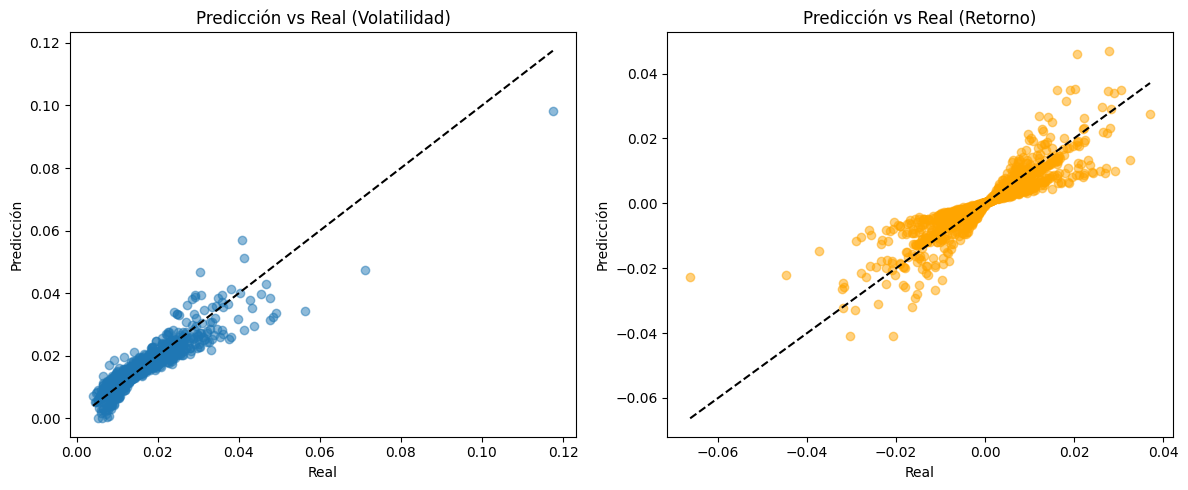

In [60]:
# 6. Visualización
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test_vol, model_vol.predict(X_test_vol), alpha=0.5)
plt.plot([y_test_vol.min(), y_test_vol.max()], [y_test_vol.min(), y_test_vol.max()], 'k--')
plt.title('Predicción vs Real (Volatilidad)')
plt.xlabel('Real')
plt.ylabel('Predicción')

plt.subplot(1, 2, 2)
plt.scatter(y_test_ret, model_ret.predict(X_test_ret), alpha=0.5, color='orange')
plt.plot([y_test_ret.min(), y_test_ret.max()], [y_test_ret.min(), y_test_ret.max()], 'k--')
plt.title('Predicción vs Real (Retorno)')
plt.xlabel('Real')
plt.ylabel('Predicción')
plt.tight_layout()
plt.show()

### Error Cuadrático Medio (MSE)

* Interpretación:

    * Penaliza más los errores grandes (por el cuadrado).

    * En tu ejemplo: Si MSE es 0.002 para volatilidad, significa que en promedio, las predicciones se desvían 0.002 unidades² del valor real.

In [61]:
from sklearn.metrics import mean_squared_error
mse_vol = mean_squared_error(y_test_vol, model_vol.predict(X_test_vol))
print(f"MSE Volatilidad: {mse_vol:.6f}")

MSE Volatilidad: 0.000009


### Error Absoluto Medio (MAE)
* Interpretacion
    * Más intuitivo que MSE (en las mismas unidades que la variable objetivo).
    * Ejemplo: MAE de 0.01 en retorno significa que, en promedio, las predicciones se desvían un 1% del retorno real.

In [62]:
from sklearn.metrics import mean_absolute_error
mae_ret = mean_absolute_error(y_test_ret, model_ret.predict(X_test_ret))
print(f"MAE Retorno: {mae_ret:.4f}")

MAE Retorno: 0.0028


### Raíz del Error Cuadrático Medio (RMSE)

* Interpretacion
    * Misma unidad que la variable dependiente (volatilidad o retorno).
    * Más sensible a outliers que MAE.

In [63]:
rmse_vol = np.sqrt(mse_vol)
print(f"RMSE Volatilidad: {rmse_vol:.4f}")

RMSE Volatilidad: 0.0029


In [66]:
import statsmodels.api as sm

# Asegurar que todas las columnas sean numéricas

X_vol_sm = sm.add_constant(X_vol)  # Intercepto + variables numéricas
model_sm = sm.OLS(y_vol.astype(float), X_vol_sm).fit()  # Asegurar que 'y' también sea float
print(model_sm.summary())

                             OLS Regression Results                             
Dep. Variable:     Volatilidad_Relativa   R-squared:                       0.834
Model:                              OLS   Adj. R-squared:                  0.834
Method:                   Least Squares   F-statistic:                     3516.
Date:                  Mon, 23 Jun 2025   Prob (F-statistic):               0.00
Time:                          21:51:56   Log-Likelihood:                 27936.
No. Observations:                  6295   AIC:                        -5.585e+04
Df Residuals:                      6285   BIC:                        -5.579e+04
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
cons

1. **R² y Adj. R²**: Explican el % de variabilidad capturada por el modelo (0.65 es decente para datos financieros).
2. **P>|t| (p-valores)**:
   - Si < 0.05, la variable es significativa (ej: `High`, `Low`, `Symbol_NEE`).
   - Si > 0.05 (ej: `Volume`), puede no aportar al modelo.
3. **Coeficientes**:
   - `High`: Aumento de 0.0008 en volatilidad por unidad de aumento en `High` (manteniendo demás constantes).
   - `Symbol_NEE`: Las acciones de NextEra Energy (NEE) tienen 0.003 más volatilidad que Duke Energy (DUK, categoría base por `drop_first=True`).
